In [2]:
import pandas as pd
coin='BNB'

#-------------------读取文件
market_data=pd.read_hdf('../cache/'+coin+'_Trade.hdf', 'data')
user_data=pd.read_excel('../cache/'+'交易结果表单3.xlsx')
#---------------------------

#-------------------市场数据降采样
market_data['time']=market_data['time'].astype('str').str.slice(0,10).astype('int64')  ## 市场数据时间戳调整为10位
market_data=market_data.drop_duplicates(subset=['time'],keep='first')  ## 去除市场数据时间戳重复
#---------------------------

#-------------------用户数据降采样到秒，同时生成时间戳字段
user_data=user_data[user_data.currency==coin]
user_data=user_data.groupby(['start time'])
user_data=user_data.apply(lambda x: 1 if 1 in x['hedge'].values else 0 ) 
user_data=user_data.to_frame().reset_index()                    ## 将时间字段退索引
user_data.columns = ['time', 'hedge']
user_data['time']=(pd.to_datetime(user_data['time']).astype('int64')//1e9).astype('int64')  ## 时间转化为时间戳
#----------------------------

#-------------------两块数据拼接并获得XY的来源序列
merged_df=pd.merge(user_data, market_data, on='time', how='left')[['time','bid1_price','hedge']]   ## 按时间戳匹配数据


2022-08-26 07:22:50    NaN
2022-08-26 07:22:51    0.0
2022-08-26 07:22:52    0.0
2022-08-26 07:22:53    0.0
2022-08-26 07:22:54    0.0
                      ... 
2022-08-26 08:00:27    0.0
2022-08-26 08:00:28    0.0
2022-08-26 08:00:29    0.0
2022-08-26 08:00:30    0.0
2022-08-26 08:00:31    0.0
Freq: S, Name: bid1_price, Length: 2262, dtype: float64


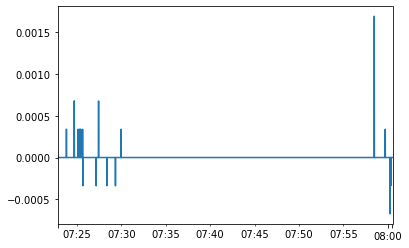

In [3]:
# 计算收益率
returns = merged_df['bid1_price'].pct_change()

# 将时间列作为索引
returns.index = pd.to_datetime(merged_df['time']*1e9)

date_range = pd.date_range(start=returns.index.min(), end=returns.index.max(), freq='1s')  ## 创建一个新的时间序列，包含缺失的时间点
returns = returns.reindex(date_range, fill_value=0)  ## 使用 reindex() 方法将原始时间序列重新索引，并将缺失的时间点填充为 0

# 绘制收益率曲线
returns.plot()
print(returns)

In [4]:
# 正收益率的部分应该做多，负收益率之前应该做空
returns_df=returns.reset_index()
returns_df.columns=['start time','returns']
returns_df.fillna(0,inplace=True)
coin='BNB'
strategy_ts=pd.read_excel('../cache/'+coin+'_策略图数据.xlsx')
strategy_ts['start time']=pd.to_datetime(strategy_ts['start time'])
ts=pd.merge(strategy_ts,returns_df,on='start time',how='left')


# 定义一个函数用于计算'suggest1'列的值
def suggest1_func(ts,x,eye=5):
    '''
    :returns 0--无建议 1--建议提前
    '''
    last_row_index = x.index[-1]
    if last_row_index + eye >= len(ts):
        return 0
    else:
        eye_flags = ts.loc[last_row_index+1:last_row_index+eye, 'returns']
        if (x['Market Making'].iloc[-1] == 'up') & ((eye_flags>=0).all()):
            return 1
        elif (x['Market Making'].iloc[-1] == 'down') & ((eye_flags<0).any()):
            return 1
        else:
            return 0


# 使用groupby()、rolling()和apply()函数生成新的DataFrame对象df2
df2 = (ts.groupby('MMgroup')
         .apply(lambda x: x.assign(suggest1=suggest1_func(ts,x,eye=10)))
         .reset_index(drop=True)
         [['MMgroup', 'suggest1']]
         .drop_duplicates())
df2=df2.drop(df2.index[0])

# 定义一个函数用于计算'suggest2'列的值

def suggest2_func(x, threshold=0.05):
    '''
    :returns 0--无建议 1--建议向下 2--建议向上
    '''
    filled_size_sum = x['filled_size'].sum()
    size_sum = x['size'].sum()
    ratio = filled_size_sum / size_sum
    if ratio >= threshold: return x.assign(suggest2=0)
    if x['Market Making'].iloc[-1] == 'up':
        return x.assign(suggest2=1)
    elif x['Market Making'].iloc[-1] == 'down':
        return x.assign(suggest2=2)
    else:
        return x.assign(suggest2=0)

# 使用groupby()、rolling()和apply()函数生成新的DataFrame对象df2
df3 =(ts.groupby('MMgroup')
        .apply(lambda x: suggest2_func(x))
        .reset_index(drop=True)
        [['MMgroup', 'suggest2']]
        .drop_duplicates())
df3=df3.drop(df3.index[0])

mm_df=pd.merge(df2,df3,on='MMgroup',how='left')

In [5]:
mm_df.to_csv('../frontend/public/dataset/策略建议.csv',index=False)

In [6]:
mm_df

,MMgroup,suggest1,suggest2
0,1,0,0
1,2,1,1
2,3,1,0
3,4,1,1
4,5,1,0
5,6,0,2
6,7,1,1
7,8,0,2
8,9,1,1
9,10,0,2


In [7]:
# 对冲策略的订单可以用资产总值变动来衡量
# 定义一个函数用于计算交易的累计盈利
def calculate_profit(df):
    df['holding_size'] = df['filled_size'].cumsum() # 计算每日持有量
    df['profit'] = df['holding_size'] * df['bid1_price'] - df['filled_size']* df['price']
    return df

# 使用apply()函数生成新的DataFrame对象df2，并添加新列'profit'
ts_fillna=ts.fillna(0)
ts_fillna['hedge_holding_size'] = ts_fillna['filled_size'].multiply(ts_fillna['hedge']).cumsum()
ts_fillna['hedge_profit'] = -  ts_fillna['hedge']*ts_fillna['filled_size']* ts_fillna['price']
ts_fillna['hedge_profit_sum']= ts_fillna['hedge_profit'].cumsum()
ts_fillna['hedge_value']=ts_fillna['hedge_holding_size'] * (ts_fillna['bid1_price']+5)+ts_fillna['hedge_profit_sum']

## 输出
ts['hedge_value']=ts_fillna['hedge_value']
ts['hedge_profit_sum']=ts_fillna['hedge_profit_sum']
ts['hedge_profit']=ts_fillna['hedge_profit']
ts['start time'] = ts['start time'].dt.strftime('%Y-%m-%d %H:%M:%S')
ts.to_excel('../cache/'+coin+'_策略图数据.xlsx',index=False)

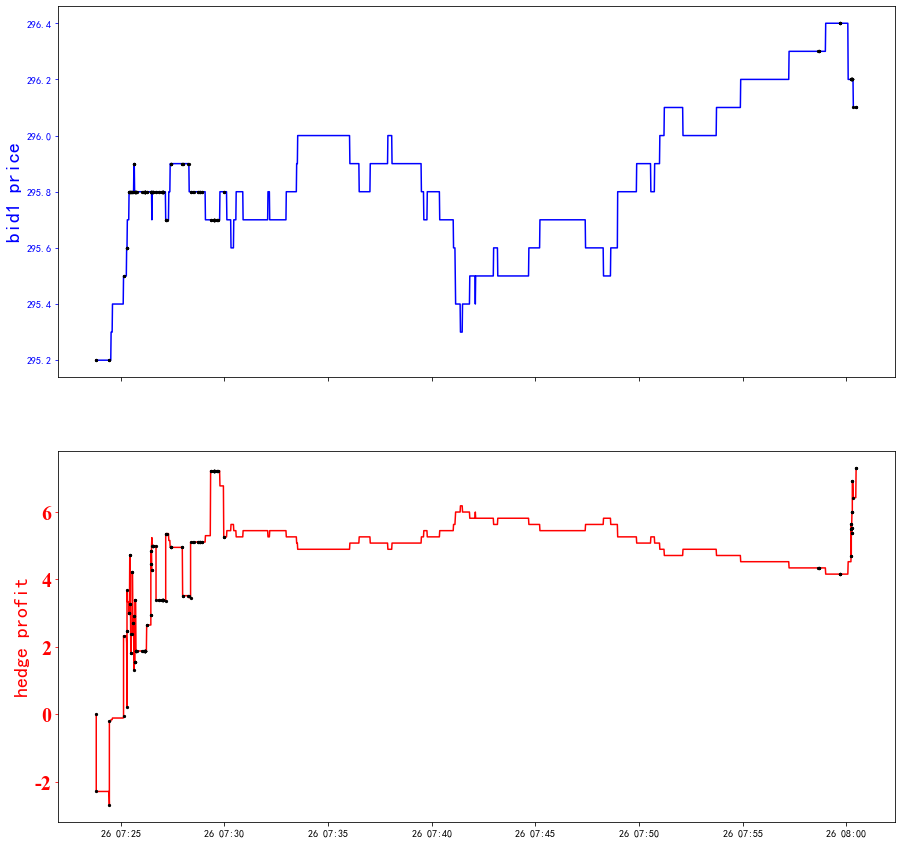

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
#####################################
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
rcParams['axes.unicode_minus'] =False
rcParams['figure.figsize'] = [15,15]
#####################################

# 将'time'列设置为索引，并转换为DatetimeIndex类型
if 'start time' in ts.columns:
    ts['start time']=pd.to_datetime(ts['start time'])
    ts.set_index('start time', inplace=True)

# 绘制DataFrame对象中'value1'和'value2'两列数据的时间序列折线图，设置左右纵坐标
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plt.yticks(fontproperties='Times New Roman', size=20,weight='bold')#设置大小及加粗

ax1.plot(ts.index, ts['bid1_price'], 'b-')
# ax1.set_xlabel('time')
ax1.set_ylabel('bid1 price', color='b',fontsize=20,fontweight='bold')
ax1.tick_params('y', colors='b')

line2 =ax2.plot(ts.index, ts['hedge_value'], 'r-')
ax2.set_ylabel('hedge profit', color='r',fontsize=20,fontweight='bold')
ax2.tick_params('y', colors='r')

mask = ts['hedge'] == 1
x = ts.loc[mask].index
y = ts.loc[mask]['bid1_price']
y2= ts.loc[mask]['hedge_value']
ax1.scatter(x, y, marker='o', color='k', zorder=10,s=5)
ax2.scatter(x, y2, marker='o', color='k', zorder=10,s=5)
plt.show()